In [1]:
import numpy as np 
import xarray as xr 
import scipy 
import matplotlib.pyplot as plt  # Plotting library
import cartopy, cartopy.crs as ccrs  # Plot maps
import random 
import satcmaps as cmaps
import image_retrieval as img
import goesRequest2 as goes 
from recenterIR import recenter_ir

In [2]:
def calculate_degrees(dataset): # Adapted from https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_abi_lat_lon.php
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = dataset['x']  # E/W scanning angle in radians
    y_coordinate_1d = dataset['y']  # N/S elevation angle in radians
    projection_info = dataset['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')

    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    x_coordinate_1d.close()
    y_coordinate_1d.close()
    projection_info.close()
    dataset.close()
    
    return abi_lat, abi_lon


In [3]:
def Gradient2D(arr, lats, lons):
    if lats.ndim == 2:
        lats = lats[:, 0]
    if lons.ndim == 2:
        lons = lons[0, :]

    dA_dlon, dA_dlat = np.gradient(arr, lats, lons, axis=(1,0))
    return dA_dlon, dA_dlat

In [4]:
def reproject(dataset, lats, lons, pos):   
    size = 3.6
    IR = dataset['CMI'].data - 273.15
                        
    # Extents and interpolation for IR
    minimglat = pos[0] - size
    maximglat = pos[0] + size
    minimglon = pos[1] - size
    maximglon = pos[1] + size
    res = 0.0179985     # degrees resolution at nadir
    grid = np.meshgrid(np.arange(minimglat, maximglat, res), np.arange(minimglon, maximglon, res))
    
    lats = lats.flatten()
    lons = lons.flatten()
    IR = IR.flatten()
    
    # Fix shape issue for boolean conditions
    floater_IR = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
                    np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(IR))

    gridded_data = scipy.interpolate.griddata((lats[floater_IR], lons[floater_IR]), IR[floater_IR], (grid[0], grid[1]), method='linear')
    
    dataset.close()

    return grid[1], grid[0], gridded_data

In [5]:
def rePoPolar(dataset, lats, lons, center = None):
    if center is None:
        clat = np.nanmean(lats)
        clon = np.nanmean(lons)
    else:
        clat, clon = center

    R = 6371.0
    cphi = np.cos(np.radians(clat))
    x = R * np.radians(lons - clon) * cphi
    y = R * np.radians(lats - clat)

    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(y, x)

    rBins = np.linspace(0, 500, 500)
    tBins = np.linspace(np.nanmin(t), np.nanmax(t), 200)

    R, T = np.meshgrid(rBins, tBins)
    newX, newY = R * np.cos(T), R * np.sin(T)
    gridded_data = scipy.interpolate.griddata((x.flatten(), y.flatten()), dataset.flatten(), (newX.flatten(), newY.flatten()), method='nearest')

    polar = xr.Dataset(
        {
            'data': (('r', 'theta'), gridded_data.reshape(R.shape).transpose())
        },
        coords={
            'r': rBins,
            'theta': tBins
        }
    )

    polar = polar.sel(r = slice(0, 500))
    polar = polar.interp(r = np.arange(0, 500, 1))

    return x, y, polar['data']


In [6]:
def run(data, polar, xkm, ykm, t):
    from scipy.ndimage import gaussian_filter1d

    ir_std = np.nanstd(polar.values, axis = 1)
    ir_std = gaussian_filter1d(ir_std, sigma = 6)
    ir_azi = np.nanmax(polar.values, axis = 1)
    radii = polar.r.values

    diff = (np.diff(ir_std) / np.diff(radii))
    diff2_std = np.diff(diff) / np.diff(radii[1:])
    diff2 = np.diff(ir_azi) / np.diff(radii)
    diff2 = gaussian_filter1d(diff2, sigma = 2)

    min_ir_rad, min_ir_radARG = radii[np.nanargmin(ir_azi)], np.nanargmin(ir_azi)
    min_ir_temp = np.nanmin(ir_azi)
    eyerad, eyeradARG = radii[np.nanargmin(diff2[:np.nanargmin(ir_azi)])], np.nanargmin(diff2[:np.nanargmin(ir_azi)]) 
    eyetemp = np.nanmax(ir_azi[radii < min_ir_rad])
    icdoedge, icdoedgeARG = (eyerad + min_ir_rad) / 2, int((eyeradARG + min_ir_radARG) / 2)
    tempArray = np.arange(0, 499, dtype = 'float32')

    temp = int(min_ir_radARG)
    thresh = min_ir_temp + 10#- (min_ir_temp / 5) 
    print('IR Threshold:', thresh)
    zeroPoint = temp + np.where((ir_azi[temp:] > thresh))[0][0]

    tempArray[0:temp] = np.nan
    tempArray[temp:] = diff[temp:]
    tempArray[zeroPoint:] = np.nan
    # ocdoedge, ocdoedgeARG = radii[np.nanargmax(tempArray)], np.nanargmax(tempArray)
    ocdoedge, ocdoedgeARG = radii[zeroPoint], zeroPoint

    # candidates = temp + np.where((diff2_std[temp:temp+100] > -0.001) & (diff2_std[temp:temp+100] < 0.001))[0]
    # candidates = np.append(candidates, ocdoedge)
    # print(candidates, np.nanmean(candidates), np.nanmedian(candidates))
    # ocdoedge, ocdoedgeARG = np.nanmax([radii[int(np.nanmean(candidates))], radii[int(np.nanmedian(candidates))]]), np.nanmax([int(np.nanmean(candidates)), int(np.nanmedian(candidates))])
    
    cdostd = np.nanmean(ir_std[icdoedgeARG:int(ocdoedgeARG)])
    print('CDO STD:', 1 / cdostd)
    print('Eye Temp: ',eyetemp, 'C\nMin CDO Temp: ', min_ir_temp, 'C')

    # # print(eyerad)
    x, y = 0, 0
        
    cmap, vmax, vmin = cmaps.irtables['bd.5']

    plt.figure(figsize = (12, 9))
    plt.pcolormesh(xkm, ykm, data, vmin = vmin, vmax = vmax, cmap = cmap, alpha = 0.5)
    circle1 = plt.Circle((x, y), eyerad, color='r', fill = False)
    plt.gca().add_patch(circle1)
    circle1 = plt.Circle((x, y), ocdoedge, color='b', fill = False)
    plt.gca().add_patch(circle1)
    circle1 = plt.Circle((x, y), icdoedge, color = 'green', fill = False)
    plt.gca().add_patch(circle1)
    circle1 = plt.Circle((x, y), min_ir_rad , color = 'black', fill = False)
    plt.gca().add_patch(circle1)

    plt.colorbar(orientation = 'vertical', aspect = 50, pad = .02)
    plt.title(f'GOES-16 Channel 13 Brightness Temperature\nSatellite Image: {t}' , fontweight='bold', fontsize=10, loc='left')
    plt.title(f'2km\nDeelan Jariwala', fontsize=10, loc='right')
    plt.savefig(r"C:\Users\deela\Downloads\testSattPlots\eyeScene1_" + t + ".png", dpi = 200, bbox_inches = 'tight')
    plt.close()

    fig, axes = plt.subplots(5, 1, sharex=True, figsize = (12, 9))

    axes[0].plot(ir_azi)
    axes[1].plot(diff2)
    axes[2].plot(ir_std)
    axes[3].plot(diff)
    axes[3].plot(diff2_std)
    # axes[3].set_ylim(-0.5, 0.5)
    axes[4].pcolormesh(polar.r, polar.theta, polar.values.T, vmin = vmin, vmax = vmax, cmap = cmap)
    axes[0].set_title('Max Infrared Brightness Temperature')
    axes[1].set_title('Radial Derivative of Averaged Infrared')
    axes[2].set_title('Standard Deviation')
    axes[3].set_title('Radial Derivative of Standard Deviation (blue), 2nd (orange)')
    axes[4].set_title('Infrared')

    # plt.axvline(min_ir_rad[index])
    for i in range(len(axes)):
        axes[i].axvline(eyerad, color = 'red', label = f'Eye {round(eyerad, 1)}km ({round(eyetemp, 1)}C)')
        axes[i].axvline(icdoedge, color = 'green', label = f'CDO Inner Edge {round(icdoedge, 1)}km')
        axes[i].axvline(ocdoedge, color = 'blue', label = f'CDO Outer Edge {round(ocdoedge, 1)}km')
        axes[i].axvline(min_ir_rad, color = 'black', label = f'Min IR Rad {round(min_ir_rad, 1)}km ({round(min_ir_temp, 1)}C)')
        axes[i].legend(loc = 'lower right')
        axes[i].axhline(0, color = 'black')

    plt.savefig(r"C:\Users\deela\Downloads\testSattPlots\eyeScene2_" + t + ".png", dpi = 200, bbox_inches = 'tight')
    # plt.show()
    plt.close()

    cdorad = ocdoedge - eyerad
    print('CDO Radius: ', cdorad) 
    # plt.show()

    return cdorad, eyerad, min_ir_temp, min_ir_rad, eyetemp, cdostd

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr 
import satcmaps as cmaps 
from scipy.ndimage import gaussian_filter
import time
import datetime as DT
from helper import invGreatCircle

globalX = np.linspace(-1, 1, 201)
globalY = np.linspace(-1, 1, 201)
globalX, globalY = np.meshgrid(globalX, globalY)

def generateVectorField(xPos, yPos):
    u = (-1 * (globalY - yPos)) - ((globalX - xPos) / 3)
    v = (globalX - xPos) - ((globalY - yPos) / 3)

    mag = np.sqrt(u**2 + v**2)

    return globalX, globalY, u / mag, v / mag

def getSpiralScore(lats, lons, data, loc, t, weight = False):
    xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)

    center = data.shape[0] // 2     
    half   = 100                    
    data = data[center - half:center + half + 1, center - half:center + half + 1]
    xkm = xkm[center - half:center + half + 1, center - half:center + half + 1]
    ykm = ykm[center - half:center + half + 1, center - half:center + half + 1]

    data = gaussian_filter(data, sigma = 2)
    fx, fy = Gradient2D(data, xkm, ykm)
    grad = np.array([fx.squeeze(), fy.squeeze()])

    if weight == True:
        # weight = (np.nanmax(data) - data) / (np.nanmax(data) - np.nanmin(data))
        weight = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
        weight = weight**(1 - np.nanmean(weight))
    else:
        weight = 1

    bestX = None
    bestY = None
    bestDot = None
    bestSum = np.inf
    bestU = None 
    bestV = None
    allSums = []
    for i in np.arange(-1, 1.01, 0.01):
        for j in np.arange(-1, 1.01, 0.01):
            x, y, u, v, = generateVectorField(i, j)
            vect = np.array([u, v])
            dot = np.nansum(grad * vect, axis = 0)
            try:
                ix = int(np.rint((i + 1) * 0.5 * (201 - 1))) 
                iy = int(np.rint((j + 1) * 0.5 * (201 - 1)))  
                ix = np.clip(ix, 0, 200)
                iy = np.clip(iy, 0, 200)
                w  = weight[ix, iy]  
            except:
                w = weight

            sums = np.nansum(np.abs(dot)) * w
            allSums.append(sums)

            if bestSum > sums and sums != 0:
                bestSum = sums
                bestX = i 
                bestY = j
                bestDot = dot
                bestU = u 
                bestV = v

    x = x * 200
    y = y * 200
    bestX = bestX * 200
    bestY = bestY * 200
    fig, axes = plt.subplots(1, 3, figsize=(18, 4.5))

    c = axes[0].pcolormesh(xkm, ykm, data, cmap = cmaps.irg()[0], vmin = -100, vmax = 50)
    axes[0].plot(bestX, bestY, marker = '*', markersize = 10, color = 'black', label = 'Spiral')
    axes[0].streamplot(x, y, bestU, bestV, linewidth = 1, density = 1, color=(0, 0, 0, 0.5))
    axes[0].set_ylim(-200, 200)
    axes[0].set_xlim(-200, 200)
    axes[0].legend(loc = 'upper right')
    axes[0].set_title('Infrared Brightness Temperature', fontsize = 8)
    axes[0].set_frame_on(False)
    c = plt.colorbar(c, ax = axes[0])
    c.ax.tick_params(labelsize = 8)
    c.set_label('Degrees Celsius', fontsize = 8)
    c.ax.set_frame_on(False)

    print('Best: ', bestX, bestY, bestSum)
    c = axes[1].pcolormesh(xkm, ykm, bestDot, vmin = -1, vmax = 1, cmap = 'RdBu_r')
    axes[1].plot(bestX, bestY, marker = '*', markersize = 10, color = 'black', label = 'Spiral')
    axes[1].streamplot(x, y, bestU, bestV, linewidth = 1, density = 1, color=(0, 0, 0, 0.5))
    axes[1].set_ylim(-200, 200)
    axes[1].set_xlim(-200, 200)
    axes[1].legend(loc = 'upper right')
    axes[1].set_title('Best Spiral ⋅ Infrared Gradient', fontsize = 8)
    axes[1].set_frame_on(False)
    c = plt.colorbar(c, ax = axes[1])
    c.ax.tick_params(labelsize = 8)
    c.ax.set_frame_on(False)

    print(np.array(allSums).shape, y.shape)

    finalSum = np.array(allSums).reshape(y.shape)
    finalSum = (finalSum - np.nanmin(finalSum)) / (np.nanmax(finalSum) - np.nanmin(finalSum))
    print(finalSum.shape)

    c = axes[2].pcolormesh(xkm, ykm, finalSum, cmap = 'RdBu_r', vmin = 0, vmax = 1)
    axes[2].plot(bestX, bestY, marker = '*', markersize = 10, color = 'black', label = 'Spiral')
    axes[2].set_ylim(-200, 200)
    axes[2].set_xlim(-200, 200)
    axes[2].legend(loc = 'upper right')
    axes[2].set_title('Sum of Spiral ⋅ Infrared Gradient', fontsize = 8)
    axes[2].set_frame_on(False)
    c = plt.colorbar(c, ax = axes[2])
    c.ax.tick_params(labelsize = 8)
    c.set_label('Normalized Sums', fontsize = 8)
    c.ax.set_frame_on(False)

    plt.suptitle(f'Spiral Score Diagnostics', fontsize = 10)
    for x in range(len(axes)):
        axes[x].tick_params(axis='both', labelsize=8)

    plt.savefig(r"C:\Users\deela\Downloads\testSattPlots\spiral_" + t + ".png", dpi = 200, bbox_inches = 'tight')
    plt.close()

    newLat, newLon = invGreatCircle(loc[0], loc[1], bestX, bestY)
    
    return newLat, newLon, bestX, bestY, bestSum

In [8]:
def getStormParams(dataset, satt, year, month, day, time, loc, locType = 'first'):
    t = f'{year}-{str(month).zfill(2)}-{str(day).zfill(2)}_{time}'
    
    allLats, allLons = calculate_degrees(dataset)
    lons, lats, data = reproject(dataset, allLats, allLons, loc)
    dataset.close()
    xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)
    if locType.lower() == 'best':
        tc_center_lon, tc_center_lat, yloc, xloc, mean_score = recenter_ir(data, xkm, ykm, 10, lons, lats)
        newLat, newLon, bestX, bestY, bestSum = getSpiralScore(lats, lons, data, loc, t, weight = True)
        if (tc_center_lat, tc_center_lon) != (np.nan, np.nan):
            loc = (tc_center_lat, tc_center_lon)
            print('New Coordinates: ', tc_center_lat, tc_center_lon)

            xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)
        else:
            print(f'No eye detected. Using Spiral Score Center ({newLat}N, {newLon}E).')
            loc = (newLat, newLon)
            xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)

    try:
        cdorad, eyerad, minIR, minIRRad, eyetemp, cdostd = run(data, polar, xkm, ykm, t)
    except Exception as e:
        print(e)
        cdorad, eyerad, minIR, minIRRad, eyetemp, cdostd = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    return [cdorad, cdostd, eyerad, eyetemp, minIR, minIRRad, bestX, bestY, bestSum]

In [9]:
import numpy as np
import xarray as xr 
import s3fs
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import datetime
import warnings 
warnings.simplefilter(action='ignore', category=UserWarning)

# Function that retrieves GOES-R data based on satellite and requested band (single band format)
# Resulting file is called "goesfile.nc"
# Data is returned at full resolution, regardless of band
def getData(satellite, year, month, day, time, loc):
    date = datetime.date(year, month, day)
    date = date.timetuple().tm_yday
    hour = time[0:2] 

    band = '13'
    fs = s3fs.S3FileSystem(anon=True)
    fs.ls('s3://noaa-goes16/')
    
    files = fs.ls(f'noaa-goes{satellite}/ABI-L2-CMIPF/{str(year)}/{str(date)}/{str(hour).zfill(2)}/')
    files = np.array(files)

    l = []
    for x in range(len(files)):
        if (f'M6C{band.zfill(2)}' in files[x]) or (f'M4C{band.zfill(2)}' in files[x]) or (f'M3C{band.zfill(2)}' in files[x]):
            l.append(files[x])
    
    for x in range(len(l)):
        if time in l[x]:
            file = l[x]

    try:
        fs.get(file, r"C:\Users\deela\Downloads\goesLoopfile.nc")
        with xr.open_dataset(r"C:\Users\deela\Downloads\goesLoopfile.nc") as data:
            params = getStormParams(data, satellite, year, month, day, time, loc, locType = 'best')
    
            data.close()
    except:
        params = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    return params

In [10]:
def zenithAngle(lat, lon, lonSat, latSat = 0):
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)
    latSat = np.deg2rad(latSat)
    lonSat = np.deg2rad(lonSat)

    beta = np.arccos(np.cos(lat - latSat) * np.cos(lon - lonSat))

    num = 42164.0 * np.sin(beta)
    den = np.sqrt(1.8084e9 - 5.3725e8 * np.cos(beta))
    theta = np.arcsin(num / den)

    return np.rad2deg(theta) 

In [11]:
import pandas as pd
import numpy as np 

try:
    CSV = pd.read_csv('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/ibtracs.ALL.list.v04r01.csv')
except:
    CSV = pd.read_csv('https://data.humdata.org/dataset/96b309bf-cedb-4f63-8ca3-eb56cdcae876/resource/d1b9b02a-53c7-4134-ada5-234efd2efec2/download/ibtracs_all_list_v04r01.csv')
prefixes = ('TOKYO', 'TD9635', 'CMA', 'HKO', 'KMA', 'NEWDELHI', 'REUNION', 'BOM', 'NADI', 'TD9636', 'WELLINGTON', 'DS824', 'NEUMANN', 'MLC')
CSV = CSV.loc[:, ~CSV.columns.str.startswith(prefixes)]

In [12]:
def getCoords(datetime, ID = None):
    stormData = CSV[(CSV.USA_ATCF_ID.astype(str) == str(ID))]
    stormData.ISO_TIME = pd.to_datetime(stormData.ISO_TIME)

    requestDT = datetime
    data = stormData.loc[[(stormData.ISO_TIME - requestDT).abs().idxmin()]]

    return data.USA_WIND.iloc[0], data.USA_PRES.iloc[0], data.USA_POCI.iloc[0], data.LAT.iloc[0], data.LON.iloc[0], data.ISO_TIME.iloc[0]

In [13]:
with open(r"C:\Users\deela\Downloads\nhcaircfixesPost2017.txt", 'r', encoding='utf-8') as data:
    data = data.read().split('\n')

In [14]:
def processData(data, fixType = 'AIRC'):
    lats = []
    lons = []
    flwi = []
    mslp = []
    atcf = []
    time = []
    for x in range(len(data)):
        temp = data[x].split(',')
        temp = [a.strip() for a in temp]
        try:
            fix = temp[4]
        except:
            fix = 'AIRC'
            print(x, temp)
        if fix == fixType:
            try:
                lat = float(temp[7][:-1]) / 100
                if temp[8][-1:] == 'E':
                    lon = float(temp[8][:-1]) / 100
                else:
                    lon = float(temp[8][:-1]) / -100

                m = int(temp[13])
                f = int(temp[39])
                id = f"{temp[0]}{temp[1]}{temp[2][:4]}"
                t = temp[2]
                t = np.datetime64(f"{t[0:4]}-{t[4:6]}-{t[6:8]}T{t[8:10]}:{t[10:12]}")
            except Exception as e:
                continue
            atcf.append(id)
            time.append(t)
            lats.append(lat)
            lons.append(lon)
            mslp.append(m)
            flwi.append(f)
    return np.array(lats), np.array(lons), np.array(mslp), np.array(flwi), np.array(atcf), np.array(time)

In [15]:
lats, lons, mslp, flwi, atcf, time = processData(data)
print(lats.shape, lons.shape, mslp.shape, flwi.shape)


3486 ['']
(2557,) (2557,) (2557,) (2557,)


In [16]:
bWind, bPres, bPOCI, bLats, bLons, bTimes = [], [], [], [], [], []
for x in range(len(atcf)):
    try:
        w, p, poci, blat, blon, btime = getCoords(time[x], atcf[x])
        bWind.append(w)
        bPres.append(p)
        bPOCI.append(poci)
        bLats.append(blat)
        bLons.append(blon)
        bTimes.append(btime)
    except:
        print(atcf[x], time[x])
bWind, bPres, bPOCI, bLats, bLons, bTimes = np.array(bWind).astype(float), np.array(bPres).astype(float), np.array(bPOCI).astype(float), np.array(bLats).astype(float), np.array(bLons).astype(float), np.array(bTimes)

EP182022 2022-10-07T13:33
EP182022 2022-10-07T14:50
EP182022 2022-10-07T16:23
EP182022 2022-10-07T16:57
EP182022 2022-10-07T23:27
EP182022 2022-10-08T00:26
EP182022 2022-10-08T01:42
EP182022 2022-10-08T03:45
EP182022 2022-10-08T04:54
EP182022 2022-10-08T11:27
EP182022 2022-10-08T12:32
EP182022 2022-10-08T14:37
EP182022 2022-10-08T16:35
EP182022 2022-10-08T22:47
EP182022 2022-10-09T00:25
EP182022 2022-10-09T00:56


In [77]:
zeniths = []
for x in range(len(bLats)):
    if bTimes[x] < np.datetime64('2018-01-01T00:00'):
        satLon = -89.5
    else:
        satLon = -72.5
    temp = zenithAngle(bLats[x], bLons[x], satLon)
    zeniths.append(temp)
zeniths = np.array(zeniths)

2541 (2541,)
[[-1.18570462]]
897.0 1015.0


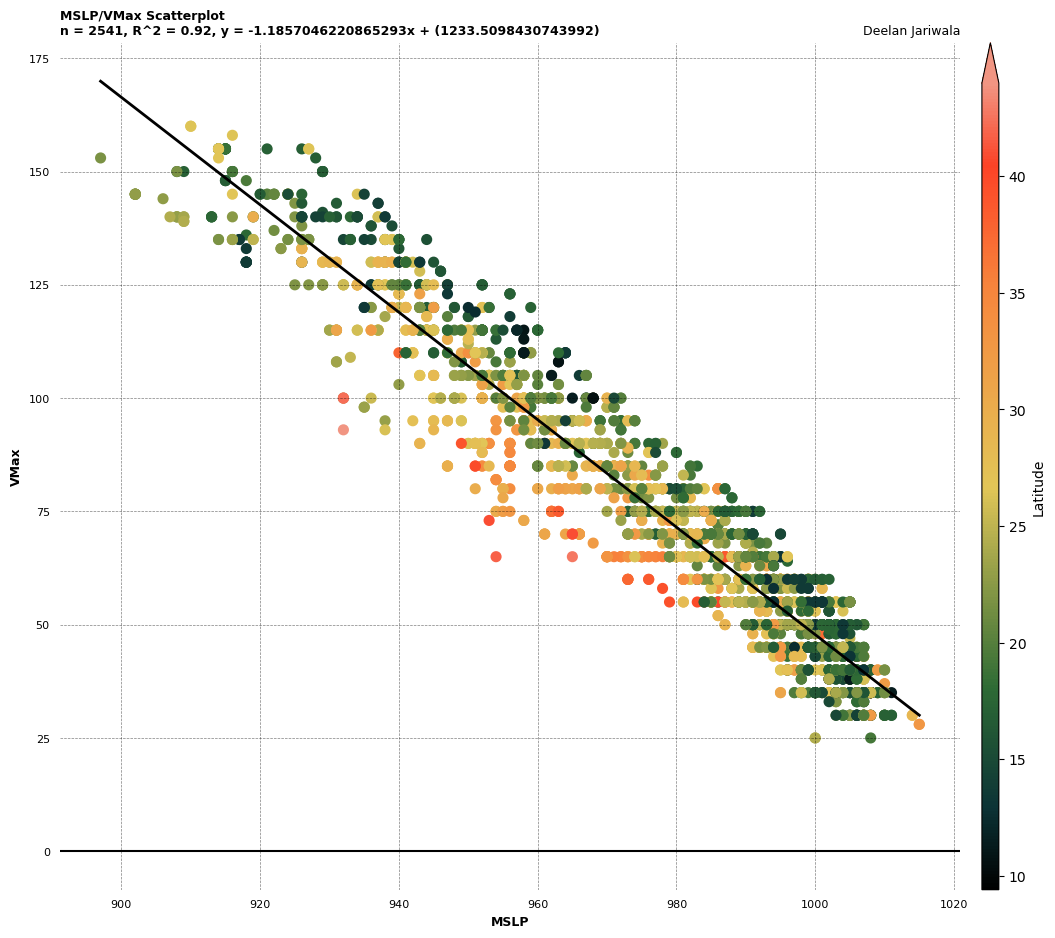

In [17]:
import defaultPlots as dp 

dp.scatter(['MSLP', bPres], ['VMax', bWind], vline = False, z = ['Latitude', bLats])

In [111]:
allData = np.loadtxt(r"C:\Users\deela\Downloads\ESTIMATES.txt", delimiter=',')


In [83]:
print(allData)

[[         nan          nan          nan          nan          nan
           nan]
 [         nan          nan          nan          nan          nan
           nan]
 [         nan          nan          nan          nan          nan
           nan]
 ...
 [ 59.          16.9058009  173.           9.94223762 -12.2749692
  194.        ]
 [ 59.          16.9058009  173.           9.94223762 -12.2749692
  194.        ]
 [ 59.          16.9058009  173.           9.94223762 -12.2749692
  194.        ]]


In [112]:
test = np.array(allData)
print(test.shape)

(2541, 6)


2541 (2541,)
[[0.32448877]]
-84.15084696662186 21.378658513590683


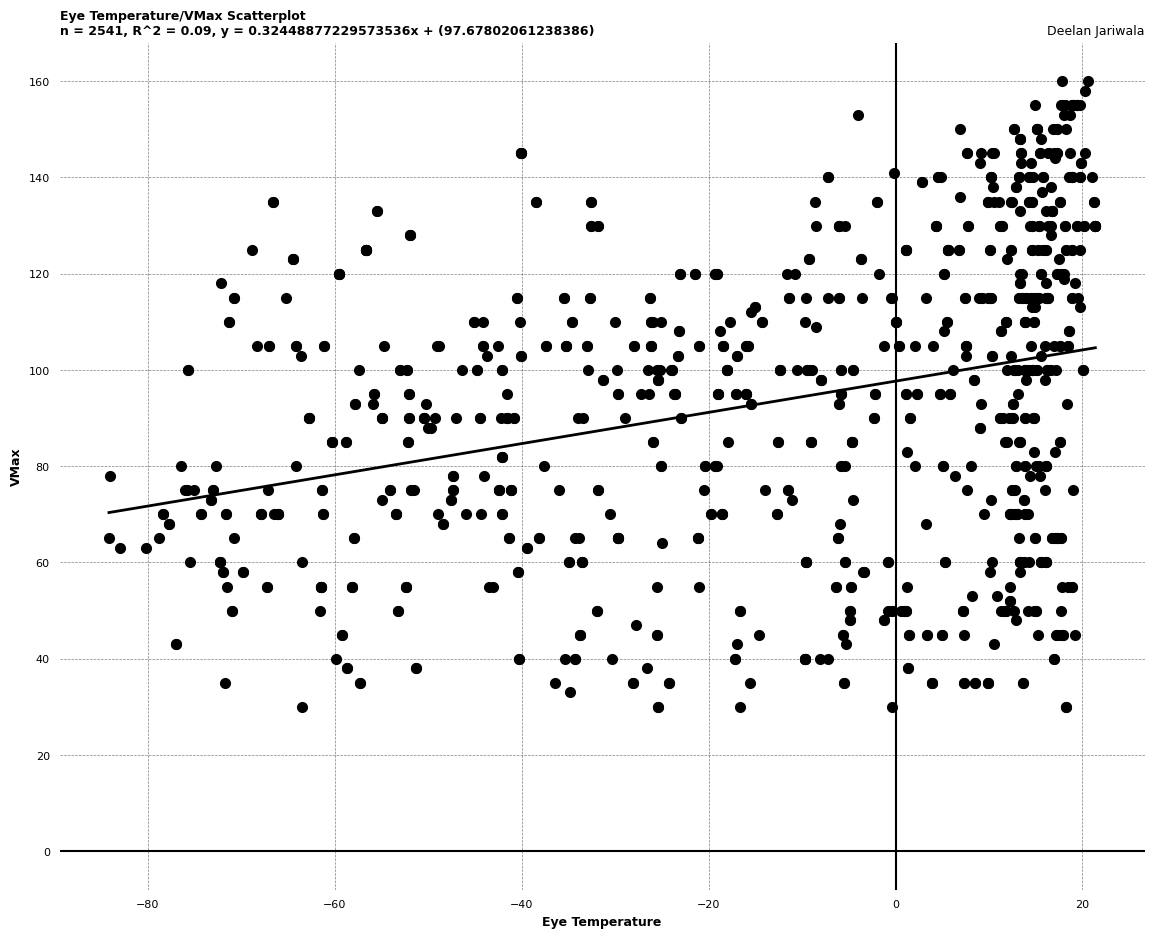

In [132]:
dp.scatter(['Eye Temperature', test[:, 3]], ['VMax', bWind])

2541 (2541,)
[[-0.89487654]]
-84.20543095719646 14.286499294492865


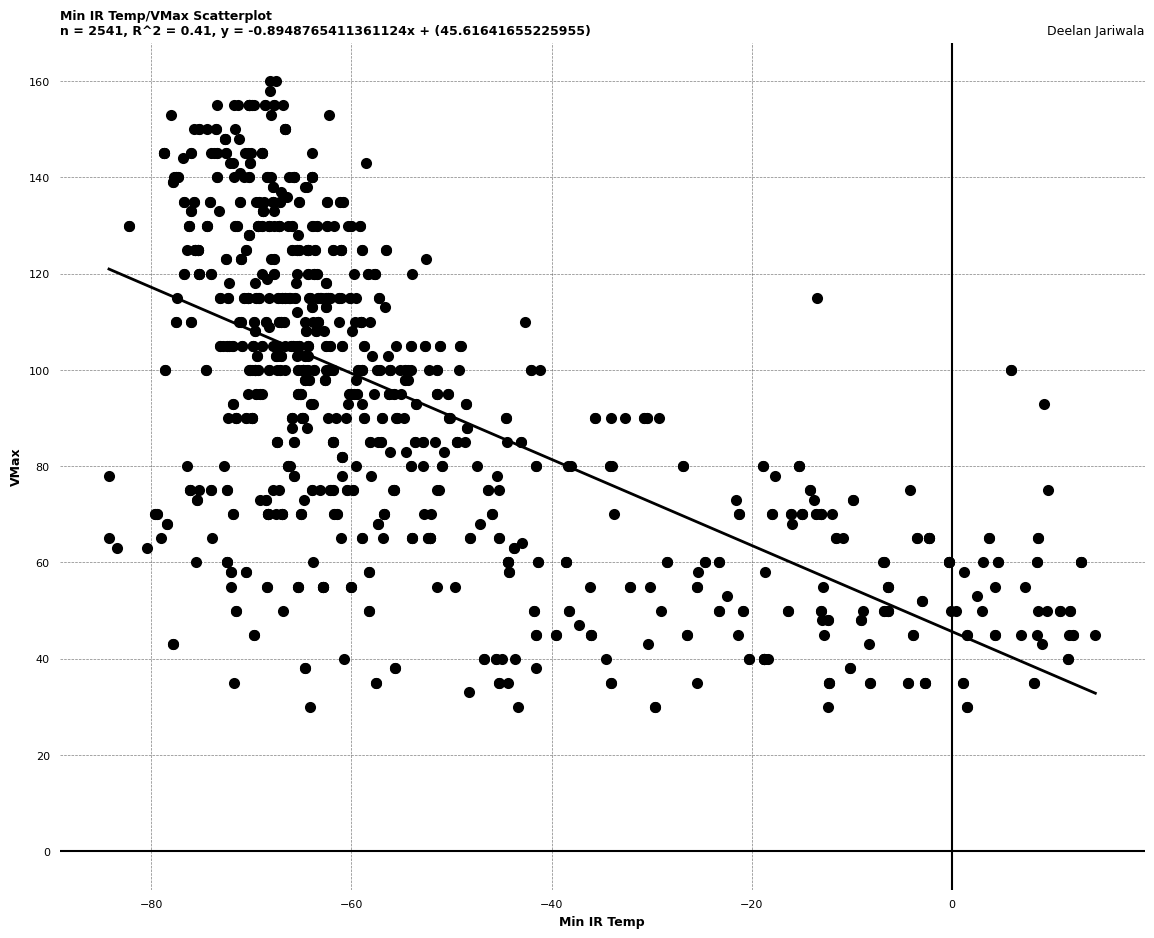

In [86]:
dp.scatter(['Min IR Temp', test[:, 4]], ['VMax', bWind])

2541 (2541,)
[[0.08608757]]
2.0 259.0


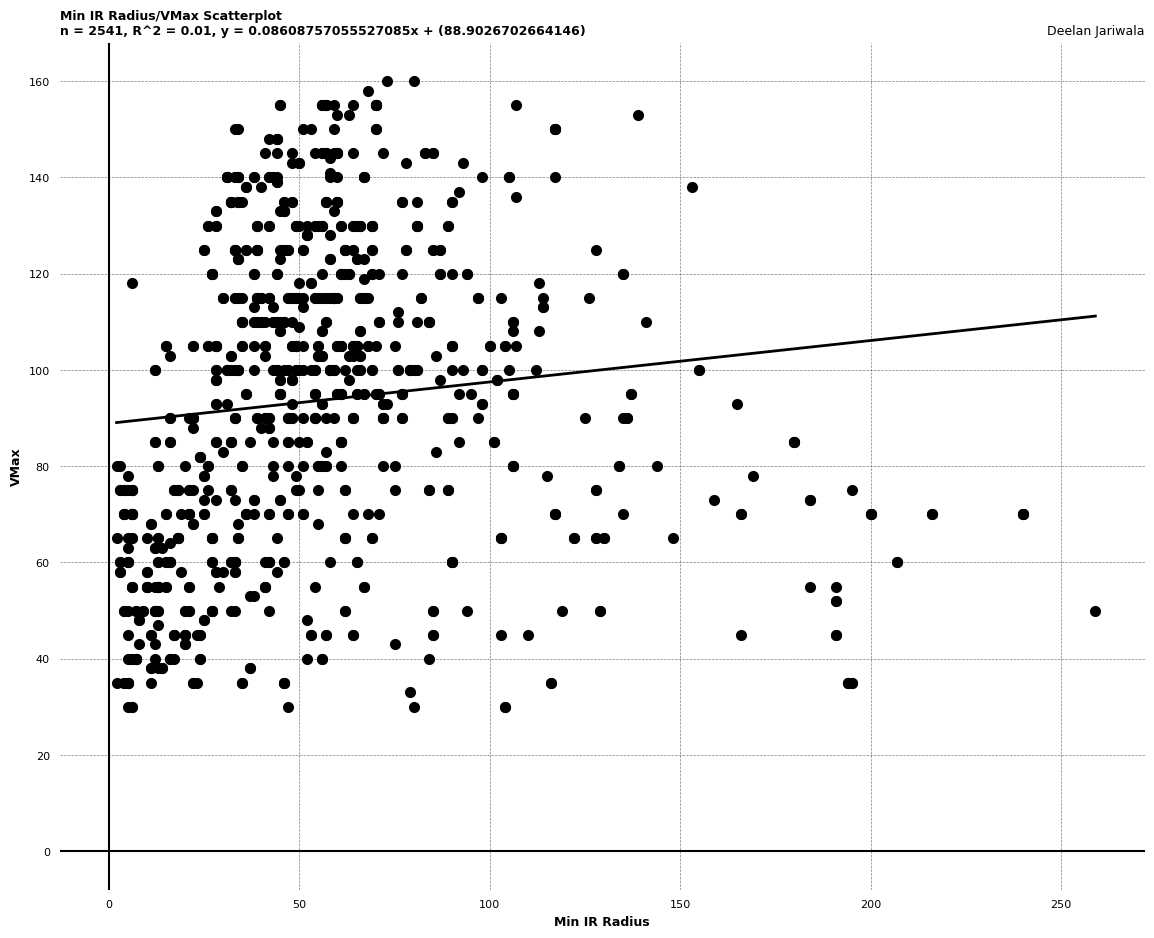

In [87]:
dp.scatter(['Min IR Radius', test[:, 5]], ['VMax', bWind])

2541 (2541,)
[[0.20950601]]
3.0 335.0


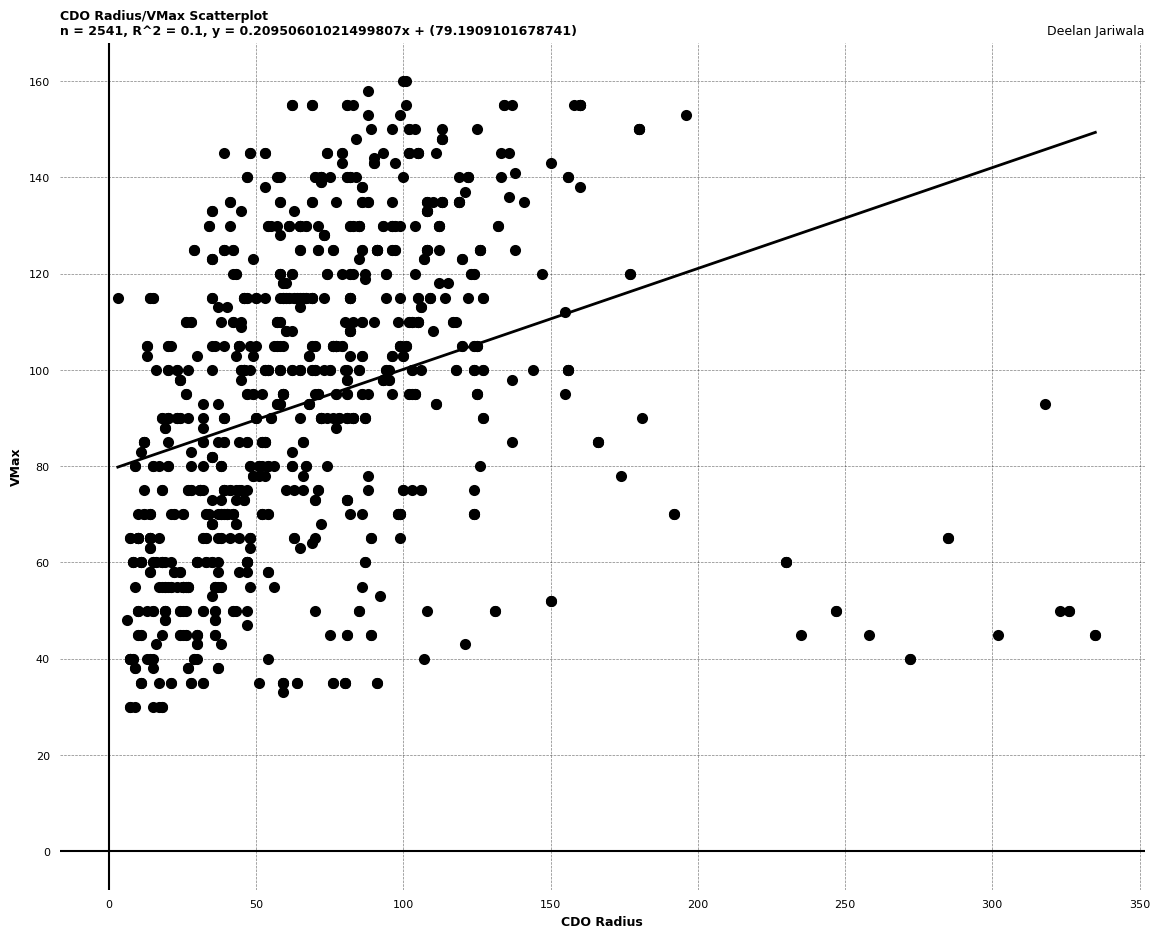

In [88]:
dp.scatter(['CDO Radius', test[:, 0]], ['VMax', bWind])

2541 (2541,)
[[-3.90090673]]
0.9191907732085475 31.208837058546113


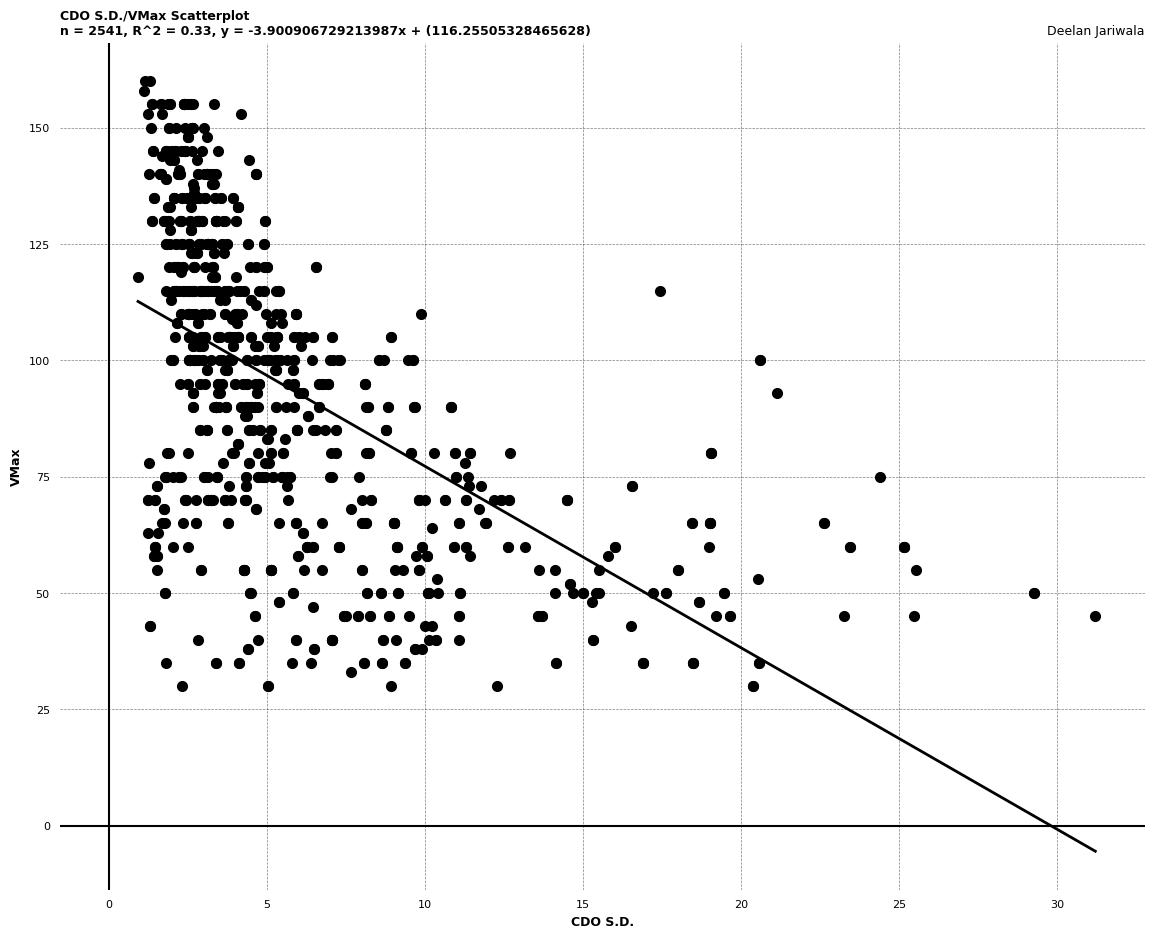

In [89]:
dp.scatter(['CDO S.D.', test[:, 1]], ['VMax', bWind])

2541 (2541,)
[[-0.20145493]]
0.0 198.0


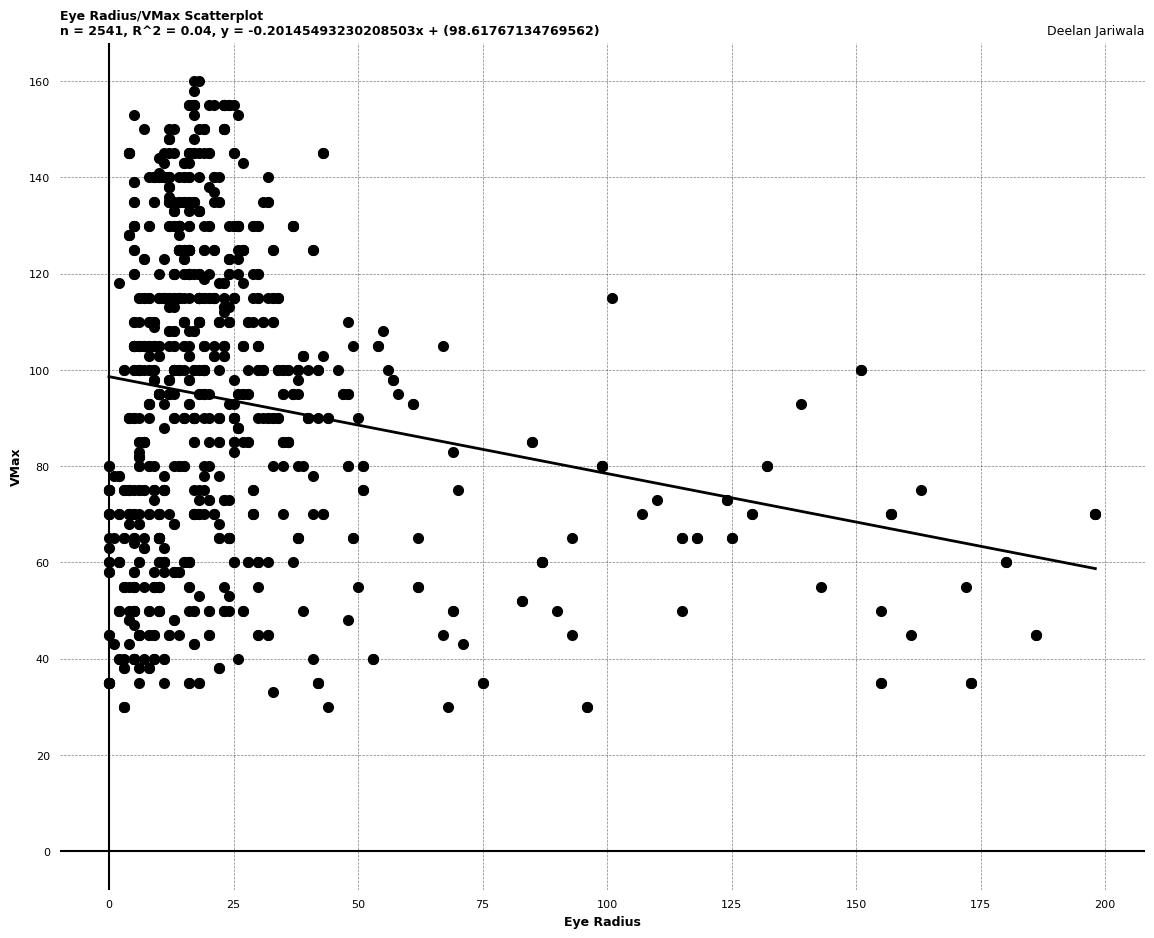

In [138]:
dp.scatter(['Eye Radius', test[:, 2]], ['VMax', bWind])

In [ ]:
def corr(t, r, theta):
    d0 = 2
    theta =  np.deg2rad(theta)
    sec = 1 / np.cos(theta)

    deff = d0 * sec

    m = (deff / (deff + 2.0 * r)) ** 1.2

    zenith_correction = 2 * (sec - 1.0)         # warms with angle
    small_eye_corr    = 6 * m                       # warms for tiny eyes, →0 for large eyes

    T_corr = t + zenith_correction + small_eye_corr

    return T_corr


2541 (2541,)
[[2.21224741]]
0.0 5.762051382780177


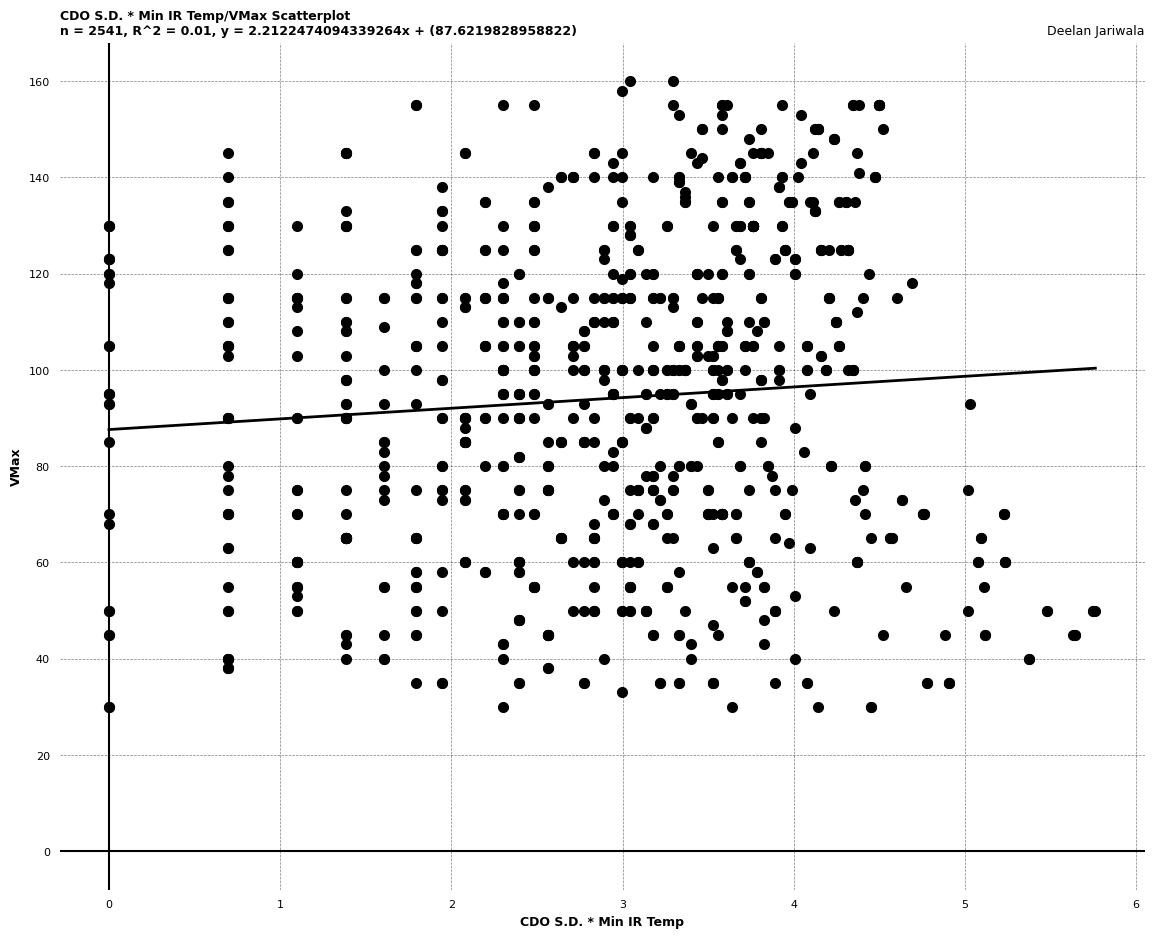

In [259]:
tPred = np.log(np.abs((test[:, 0] - test[:, 5])))
dp.scatter(['CDO S.D. * Min IR Temp', tPred], ['VMax', bWind])


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import scipy 
import requests
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def regression(input, output, RF = True, GB = False, poly = False): 
    print(input.shape, output.shape)    
    trainIn = input[:700]
    trainOut = output[:700]
    testIn = input[700:]
    testOut = output[700:]

    if RF == True:
        regr = RandomForestRegressor(n_estimators=200, n_jobs=-1)#, max_features = 0.75, max_depth = 25)
        regr.fit(trainIn, trainOut) 
        predictTest = regr.predict(testIn)
    elif GB == True:
        regr = XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='reg:squarederror',
            random_state=42
        )
        regr.fit(trainIn, trainOut)
        predictTest = regr.predict(testIn)
    elif poly == True:
        regr = make_pipeline(
            PolynomialFeatures(degree=2, include_bias=False),
            LinearRegression()
        )
        regr.fit(trainIn, trainOut)
        predictTest = regr.predict(testIn)
    else:
        regr = linear_model.LinearRegression()
        regr.fit(trainIn, trainOut)
        predictTest = regr.predict(testIn)

    try:
        importance = regr.feature_importances_
    except:
        try:
            coef = np.abs(regr.coef_ * np.nanstd(input, axis = 0))
            importance = coef / np.sum(coef)
        except:
            importance = None
            pass 

    corr, sig = scipy.stats.pearsonr(predictTest, testOut)
    error2 = np.sqrt(np.mean((predictTest - testOut)**2))
    error = np.mean(np.abs(predictTest - testOut))
    dp.scatter(['Predicted VMax (kt)', predictTest], ['VMax (kt)', testOut])#, hline = False, vline = False)

    print(str(error) + f"kt MAE\n{str(error2)}kt RSME\nR^2: {corr**2}")

    return regr, predictTest, importance, testIn, testOut

(9, 2541)
0 CDO Radius 2541
1 CDO S.D. 2541
2 Eye Radius 2541
3 Eye Temp. 2541
4 Min. IR Temp. 2541
5 Min. IR Radius 2541
6 Latitude 2541
7 Zenith Angle 2541
8 Test 2541
(969, 9) (969,)
269 (269,)
[[1.0818822]]
42.04905 151.05339


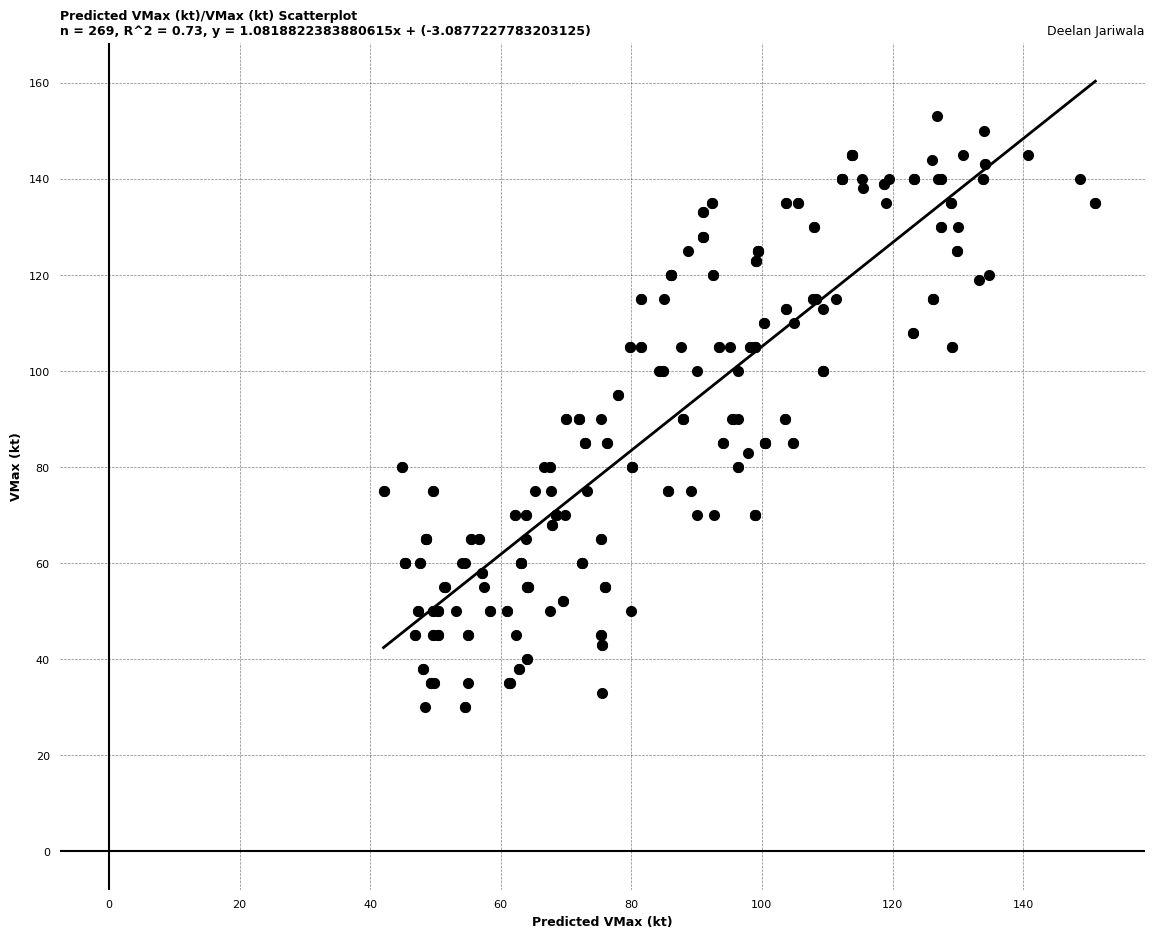

15.17397262970311kt MAE
18.385546727789215kt RSME
R^2: 0.7250744940971882
Feature:                          CDO Radius, Importance: 0.015316171571612358
Feature:                            CDO S.D., Importance: 0.08798463642597198
Feature:                          Eye Radius, Importance: 0.036548808217048645
Feature:                           Eye Temp., Importance: 0.25506848096847534
Feature:                       Min. IR Temp., Importance: 0.3956720530986786
Feature:                      Min. IR Radius, Importance: 0.09460532665252686
Feature:                            Latitude, Importance: 0.0527704656124115
Feature:                        Zenith Angle, Importance: 0.0353301540017128
Feature:                                Test, Importance: 0.02670394629240036




In [260]:
xNames = ['CDO Radius', 'CDO S.D.', 'Eye Radius', 'Eye Temp.', 'Min. IR Temp.', 'Min. IR Radius', 'Latitude', 'Zenith Angle', 'Test']
x = test.T
# x = np.delete(x, 1, axis = 0)
x = np.vstack((x, bLats))
x = np.vstack((x, zeniths))
x = np.vstack((x, tPred))
print(x.shape)
y = bWind

for i, (name, arr) in enumerate(zip(xNames, x)):
    print(i, name, len(arr))

x = [np.asarray(a, dtype=float) for a in x]
# mask = x[] < 50         
# x = [a[mask] for a in x]
# y = y[mask]

y = np.where(y == 9999, np.nan, y)

# Start with a mask of all True
mask = ~np.isnan(y) & ~np.isinf(y)

# Update the mask based on each predictor
for i in range(len(x)):
    mask = mask & ~np.isnan(x[i]) & ~np.isinf(x[i])

# Apply the final mask to each predictor
for i in range(len(x)):
    x[i] = x[i][mask]
    # x[i] = norm(x[i])

# Apply the mask to the target
y = y[mask]

# Stack predictors into 2D array and regress
x = np.column_stack(x)

regr, predictTest, importance, testIn, testOut= regression(x, y, RF = False, GB = True, poly = False)

# import pickle
# with open(r"C:\Users\deela\Downloads\predVMAXv2.cpickle", 'wb') as f:
#     pickle.dump(regr, f)

feat = dict(zip(xNames, importance))
# Print one key-value pair at a time
for key, value in feat.items():
    print(f"Feature: {key:>35}, Importance: {value}")
print('\n')
# for x in range(len(storm_name)):
#     print(storm_name[x], y[x], predictTest[x])

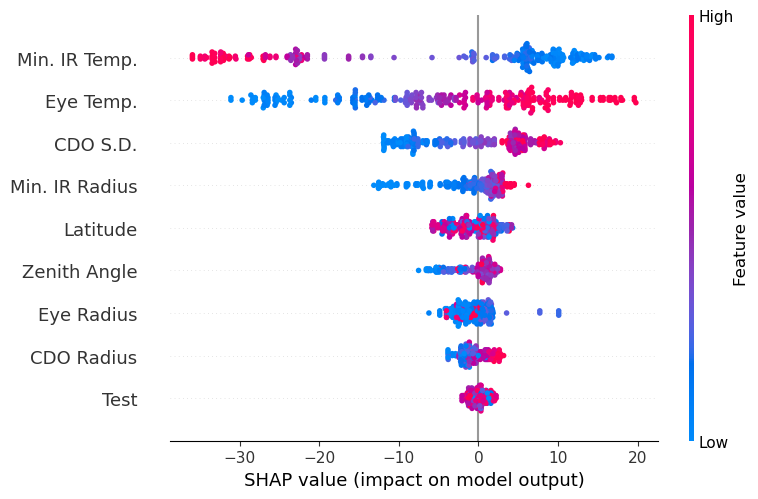

In [262]:
import shap

explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(testIn)

fig, ax = plt.subplots(figsize=(10, 5))
shap.summary_plot(shap_values, testIn, feature_names=xNames, show=False)
plt.tight_layout()
plt.show()

# import pickle
# with open(r"C:\Users\deela\Downloads\predVMAXSHAPv2.cpickle", 'wb') as f:
#     pickle.dump(explainer, f)

In [30]:
print(regr.coef_, regr.intercept_)

AttributeError: Coefficients are not defined for Booster type None

In [ ]:
stormParams = [np.int64(107), np.float64(1.2655676974824834), np.int64(14), np.float64(22.007186415188237), np.float64(-72.16324355252097), np.int64(81), np.float64(23.017698500000183)]

a = regr.predict([stormParams])
print(a, 0.922 * a + 11.55)

In [ ]:
dp.scatter(['Min IR Temp', x[:, 4]], ['Inverse of CDO S.D.', 1 / x[:, 1]], z = ['VMax', y])

In [ ]:
param = np.sin(np.x[:, 6])
# param = np.where(param < 0.01, param, np.nan)
# param = np.where(param > -0.01, param, np.nan)
dp.scatter(['test', param], ['VMax.', y])

In [ ]:
dp.scatter(['CDO Radius', test[:, 2]], ['Minimum IR Radius', test[:, 5]])

(10, 969)


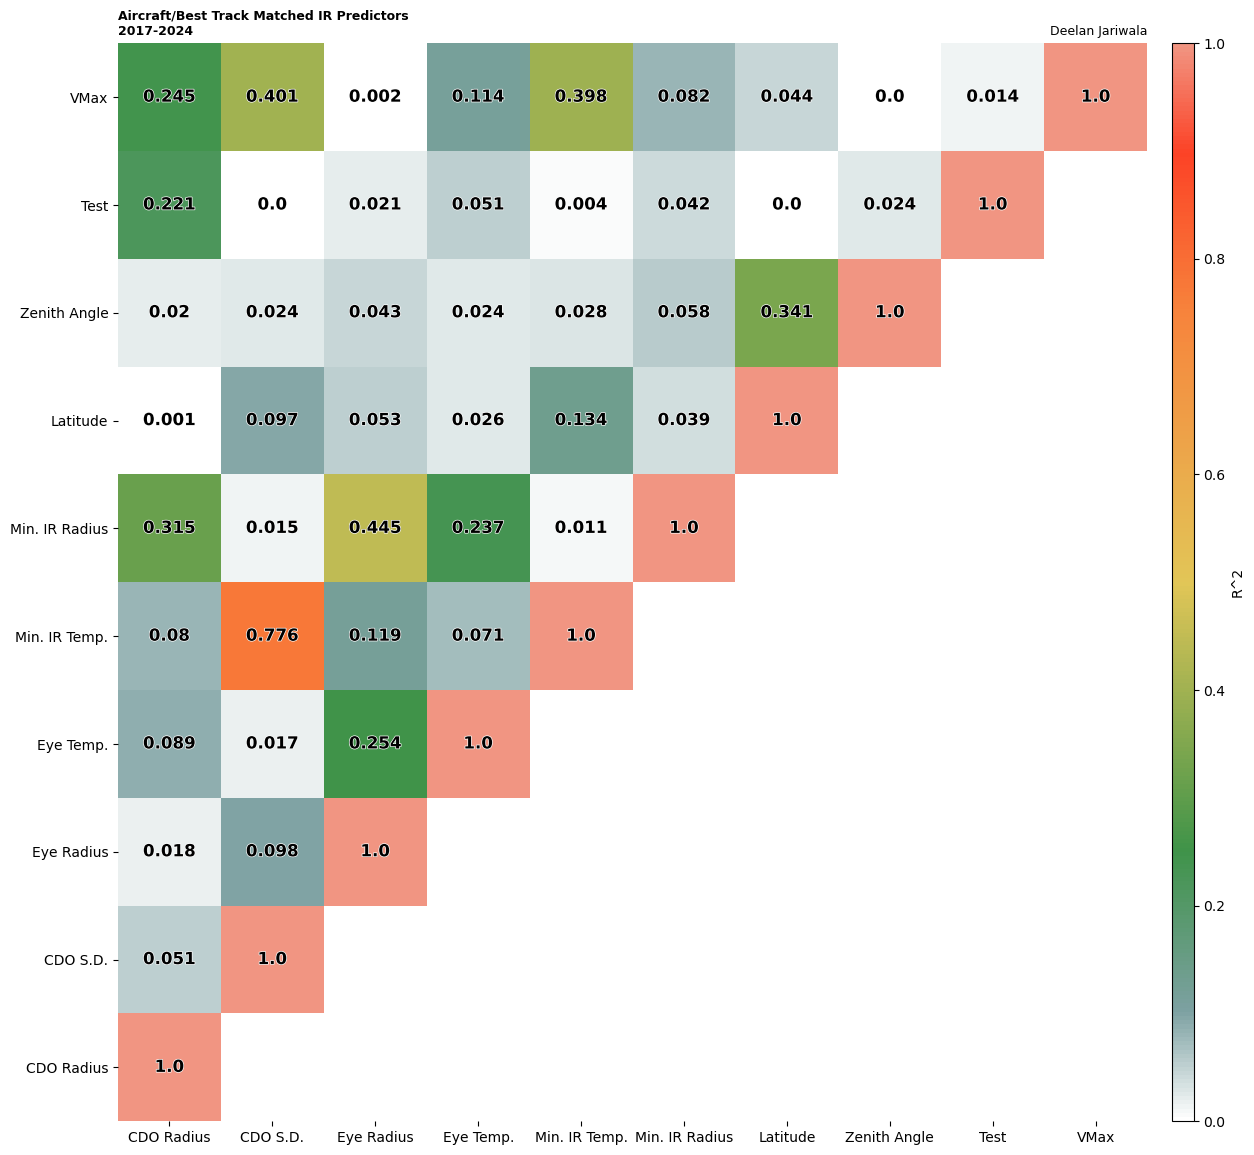

In [261]:
import cmaps as cmap 
from matplotlib import patheffects as pe
from scipy import stats

corrList = []
var = np.vstack((x.T, y))
variables = var
names = xNames.copy()
names.append('VMax')

print(variables.shape)
labelsize = 9 

for i in range(len(variables)):
    for j in range(len(variables)):
        if i >= j:
            # corr, sig = scipy.stats.pearsonr(variables[i], variables[j])
            corr, sig = scipy.stats.spearmanr(variables[i], variables[j])
            corrList.append(corr**2)
        else:
            corrList.append(0)

corrList = np.array(corrList).reshape(len(variables), len(variables))

fig = plt.figure(figsize=(16, 14))
ax = plt.axes()
ax.set_frame_on(False)
ax.set_xticks(np.arange(len(variables)))
ax.set_xticklabels(names) 
ax.set_yticks(np.arange(len(variables)))
ax.set_yticklabels(names) 

s = plt.pcolormesh(np.arange(len(variables)), np.arange(len(variables)), corrList, cmap = cmap.probs(), vmin = 0, vmax = 1)
for i in range(len(variables)):
    for j in range(len(variables)):
        if i >= j:
            if sig < 0.05:
                plt.text(j, i, f'{(round(corrList[i][j], 3))}', size=12, color='black', weight = 'bold', horizontalalignment = 'center', verticalalignment = 'center', path_effects=[pe.withStroke(linewidth = 1, foreground="white")])#, transform = ccrs.PlateCarree(central_longitude = 0))
            else:
                plt.text(j, i, f'{(round(corrList[i][j], 3))}', size=12, color='black', horizontalalignment = 'center', verticalalignment = 'center', path_effects=[pe.withStroke(linewidth = 1, foreground="white")])

cbar = plt.colorbar(s, orientation = 'vertical', aspect = 50, pad = .02)
cbar.set_label("R^2")

ax.set_title(f'Aircraft/Best Track Matched IR Predictors\n2017-2024', fontweight='bold', fontsize=labelsize, loc='left')  
ax.set_title(f'Deelan Jariwala', fontsize=labelsize, loc='right')
# plt.savefig(r"C:\Users\deela\Downloads\IRPredcorrMatrix.png", dpi = 400, bbox_inches = 'tight')
plt.show()
